In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import importlib
from tqdm import tqdm

import sys
sys.path.append('..')
import controllers 
import env.system as system
import env.env_gym as env_gym
import utils

In [9]:
df_disturbances= pd.read_csv('disturbances//output.csv')
time= pd.to_datetime(df_disturbances['time'])
temperature= np.array(df_disturbances.loc[:,'temperature'])
raw_irrandiance= np.array(df_disturbances.loc[:,'irradiance'])
irradiances= 0.25*np.tile(raw_irrandiance,(4,1))
disturbance= np.concatenate((temperature.reshape(-1,1), irradiances.T),axis=1)

In [10]:
t0= 2000
dt= 4*60
v_hourly= disturbance[t0:t0+dt,:]
ep_time= time.iloc[t0:t0+dt]

In [11]:
importlib.reload(system)
importlib.reload(env_gym)

############### PARAMS ##################
observation_index= 1
action_index=  12
distrubance_index= [3,4,5,6,7]
########################################

model_type= 'continuous'  # 'continuous' or 'discrete'
data_path= '../data/'     # Path to the data directory
model_data = sio.loadmat(data_path + model_type + '_time_model.mat',mat_dtype= True)
A= model_data['model'][0][0][0]
Bu= model_data['model'][0][0][1]
Bv= model_data['model'][0][0][2]
Bvu= model_data['model'][0][0][3]
Bxu= model_data['model'][0][0][4]

N= 390  # system state variable size
M= 13   # system control variable size
V= 9    # system disturbance size
No= len(observation_index) if type(observation_index) is list else 1 # observations size
Ma= len(action_index)      if type(action_index) is list else 1      # action size
V_= len(distrubance_index) if type(distrubance_index) is list else 1 # disturbance size

umin= np.array([0]).reshape((Ma,1))
umax= np.array([100]).reshape((Ma,1))
model= {}
model['A']= A
model['Bu']= Bu
model['Bv']= Bv[:,distrubance_index].reshape((N,V_))
model['Bvu']= Bvu[:,distrubance_index,:].reshape((N,V_,M))
model['Bxu']= Bxu

dt = 15                         # seconds time step
T= v_hourly.shape[0]            # Number of time steps
x_t = np.ones((No,1))*23        # Desired temperature
x0= np.ones((N,1))*20           # Initial state
v= v_hourly.T                   # Disturbances (outdoor temperature and irradiances)

# Initialize the system model and environment
system_model= system.Continuous(model, x0, x_t, v,
                              observation_index,
                              action_index,
                              dt= dt)
env_= env_gym.Env(system= system_model,
                      o_dim= No,
                      a_dim= Ma,
                      umin= umin,
                      umax= umax,
                      T=T)

### check

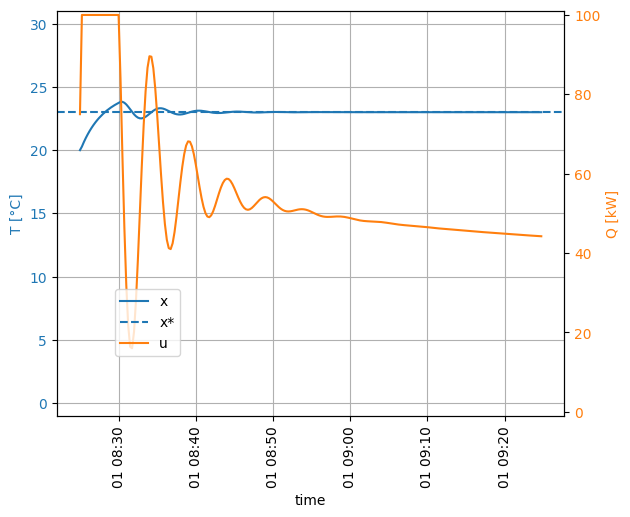

In [24]:
importlib.reload(controllers)
importlib.reload(utils)

piddino= controllers.PID(Kp= 1 , Ki= 0.1 , Kd=0.0, 
                setpoint= x_t[0][0], 
                umin= umin[0][0], 
                umax= umax[0][0], 
                dt=dt)
states, actions, rewards, sys_states= utils.pid_trajectory(env_, v, x0, piddino)
utils.plot_test(time= ep_time, states= states, x_t= x_t, actions= actions, 
                v_test= None, umin= umin-1, umax= umax+1)

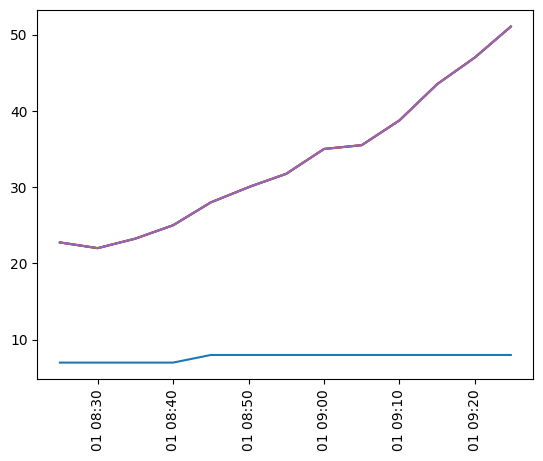

In [13]:
plt.plot(ep_time,v.T)
plt.xticks(rotation=90)
plt.show()

### simulations

In [31]:
ks= list(np.logspace(-1,1,10))
t0= 100000
dt= 4*60
v= disturbance[t0:t0+dt,:].T

simulations_info= pd.DataFrame(columns=['Kp','Ki','Total Reward','Tracking Reward','Cost Reward','Precision Reward'])
c=-1
for k in tqdm(ks):
    for k_ in ks:
        c=c+1

        piddino= controllers.PID(Kp= k , Ki= k_ , Kd=0.0)
        states, actions, rewards, sys_states= utils.pid_trajectory(env_, v, x0, piddino)

        # if c==5:
        #     utils.plot_test(time= ep_time, states= states, x_t= x_t, actions= actions, 
        #         v_test= None, umin= umin-1, umax= umax+1)

        simulations_info.loc[c,:] = [k, k_, 
            *utils.episodic_rewards(env_.system, np.array(states), np.array(actions))]

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


In [32]:
simulations_info

,Kp,Ki,Total Reward,Tracking Reward,Cost Reward,Precision Reward
0,0.1,0.1,-46162.508967,-29580.312865,-16386.561118,-195.634985
1,0.1,0.16681,-39626.836746,-22466.553155,-16955.635113,-204.648478
2,0.1,0.278256,-33762.398537,-16493.155759,-17056.877027,-212.365752
3,0.1,0.464159,-29569.062518,-12383.757191,-16966.906617,-218.39871
4,0.1,0.774264,-27064.335874,-9929.016094,-16912.887882,-222.431898
...,...,...,...,...,...,...
95,10.0,1.29155,-24949.786348,-7859.331412,-16863.233255,-227.221681
96,10.0,2.154435,-24643.634553,-7615.348027,-16799.884452,-228.402074
97,10.0,3.593814,-51270.243463,-23879.823053,-27222.52813,-167.892279
98,10.0,5.994843,-54690.985646,-27525.113409,-27000.0,-165.872237
